In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# import tensorflow_addons as tfa

from kaggle_datasets import KaggleDatasets

import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)


    
print(tf.__version__)

2025-06-06 01:20:38.044366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749172838.279767      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749172838.334541      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Number of replicas: 1
2.18.0


In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt

In [3]:
!pip install tensorflow-addons


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 10.0 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [4]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# import tensorflow_addons as tfa

In [5]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [6]:
# Replace GCS_PATH with your dataset directory path
DATA_PATH = '/kaggle/input/real-to-ghibli-image-dataset-5k-paired-images'

# Image file paths using tf.io.gfile.glob
REAL_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/dataset/trainA/*.jpg'))
print('Real Photo Files:', len(REAL_FILENAMES))

GHIBLI_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/dataset/trainB_ghibli/*.jpg'))
print('Ghibli-style Files:', len(GHIBLI_FILENAMES))

Real Photo Files: 2500
Ghibli-style Files: 2500


In [7]:
IMAGE_SIZE = [256, 256]

def decode_image(filename):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    # image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

# def read_tfrecord(example):
#     tfrecord_format = {
#         "image_name": tf.io.FixedLenFeature([], tf.string),
#         "image": tf.io.FixedLenFeature([], tf.string),
#         "target": tf.io.FixedLenFeature([], tf.string)
#     }
    # example = tf.io.parse_single_example(example, tfrecord_format)
    # image = decode_image(example['image'])
    # return image

In [8]:
def load_dataset(file_paths):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)   
    # dataset = dataset.map(lambda x, y: (tf.reshape(x, [256, 256, 3]), tf.reshape(y, [256, 256, 3])))

    return dataset

In [9]:
real_ds = load_dataset(REAL_FILENAMES).batch(3)
ghibli_ds = load_dataset(GHIBLI_FILENAMES).batch(3)

I0000 00:00:1749172861.343436      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [10]:
example_real = next(iter(real_ds))
example_ghibli = next(iter(ghibli_ds))

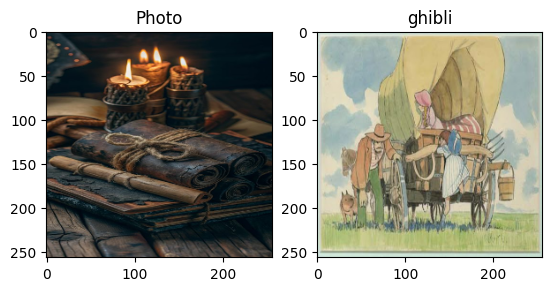

In [11]:
plt.subplot(121)
plt.title('Photo')
plt.imshow(example_real[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('ghibli')
plt.imshow(example_ghibli[0] * 0.5 + 0.5)

**Build The Generator**


In [12]:
def create_downsample_layers(model):
    # 64x7x7 conv, stride 1
    model.add(layers.Conv2D(64, (7, 7), strides=(1, 1), padding="SAME", input_shape=[256, 256, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 256, 256, 64)
    
    #128x3x3 conv, stride 2
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 128, 128, 128)
    
    # 256x3x3 conv, stride 2
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 64, 64, 256)

def create_residual_block(model):
    # 256x3x3 conv
    model.add(layers.Conv2D(256, (3, 3),padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.Conv2D(256, (3, 3),padding="SAME"))
    model.add(layers.BatchNormalization())
    
def create_residual_blocks(model, num_blocks):
    for i in range(num_blocks):
        create_residual_block(model)
        
def create_upsample_layers(model):
    # 128x3x3 convTranspose, stride 2
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 128,128, 128)
    
    # 64x3x3 convTranspose, stride 2
    model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    assert model.output_shape == (None, 256, 256, 64)
    
    # 3x7x7 conv, stride 1
    model.add(layers.Conv2D(3, (7, 7), strides=(1, 1), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation(tf.keras.activations.tanh))
    assert model.output_shape == (None, 256, 256, 3)

def create_generator():
    model = tf.keras.models.Sequential()
    
    create_downsample_layers(model)
    assert model.output_shape == (None, 64, 64, 256)
    
    create_residual_blocks(model, 9)
    assert model.output_shape == (None, 64, 64, 256)
    
    create_upsample_layers(model)
    assert model.output_shape == (None, 256, 256, 3)
    
    return model

In [13]:
assert create_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Discriminator**# 

In [14]:
from keras.optimizers import Adam

In [15]:
def create_discriminator():
    model = tf.keras.models.Sequential()
    
    # 64x4x4 conv, stride 2
    model.add(layers.Conv2D(64, (4, 4), strides=(2, 2), padding="SAME", input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 128, 128, 64)
    
    # 128x4x4 conv, stride 2
    model.add(layers.Conv2D(128, (4, 4), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 64, 64, 128)
    
    # 256x4x4 conv, stride 2
    model.add(layers.Conv2D(256, (4, 4), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 32, 32, 256)
    
    # 512x4x4 conv, stride 2
    model.add(layers.Conv2D(512, (4, 4), strides=(2, 2), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 16, 16, 512)
    
    # 512x4x4 conv, stride 1
    model.add(layers.Conv2D(512, (4, 4), padding="SAME"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    assert model.output_shape == (None, 16, 16, 512)
    
    # 1x4x4 conv, stride 1
    model.add(layers.Conv2D(1, (4, 4), strides=(1, 1), padding="SAME"))
    assert model.output_shape == (None, 16, 16, 1)
    model.compile(loss='mse', optimizer=keras.optimizers.Adam( beta_1=0.5), loss_weights=[0.5])
    
    return model

In [16]:
assert create_discriminator()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [17]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

In [18]:
with strategy.scope():
    ghibli_generator = create_generator() 
    photo_generator = create_generator() 

    ghibli_discriminator = create_discriminator() 
    photo_discriminator = create_discriminator() 

I0000 00:00:1749172867.328721      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


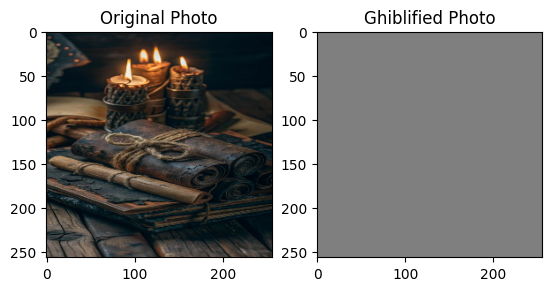

In [19]:
to_ghibli = ghibli_generator(example_real)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(example_real[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Ghiblified Photo")
plt.imshow(to_ghibli[1] * 0.5 + 0.5)
plt.show()

# Build the CycloGAN Model 

In [20]:
class cycleGAN(keras.Model):
    def __init__(
        self,
        ghibli_generator, 
        real_generator,
        ghibli_discriminator,
        real_discriminator,
        lambda_cycle=10,
    ):
        super(cycleGAN, self).__init__()
        self.g_gen = ghibli_generator
        self.r_gen = real_generator
        self.g_disc = ghibli_discriminator
        self.r_disc = real_discriminator
        self.lambda_cycle = lambda_cycle
    def compile(
        self,
        g_gen_optimizer,
        r_gen_optimizer,
        g_disc_optimizer,
        r_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(cycleGAN, self).compile()
        self.g_gen_optimizer = g_gen_optimizer
        self.r_gen_optimizer = r_gen_optimizer
        self.g_disc_optimizer = g_disc_optimizer
        self.r_disc_optimizer = r_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_ghibli, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_ghibli = self.g_gen(real_photo, training=True)
            cycled_photo = self.r_gen(fake_ghibli, training=True)

            # monet to photo back to monet
            fake_photo = self.r_gen(real_ghibli, training=True)
            cycled_ghibli = self.g_gen(fake_photo, training=True)

            # generating itself
            same_ghibli = self.g_gen(real_ghibli, training=True)
            same_photo = self.r_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_ghibli = self.g_disc(real_ghibli, training=True)
            disc_real_photo = self.r_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_ghibli = self.g_disc(fake_ghibli, training=True)
            disc_fake_photo = self.r_disc(fake_photo, training=True)

            # evaluates generator loss
            ghibli_gen_loss = self.gen_loss_fn(disc_fake_ghibli)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_ghibli, cycled_ghibli, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_ghibli_gen_loss = ghibli_gen_loss + total_cycle_loss + self.identity_loss_fn(real_ghibli, same_ghibli, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            ghibli_disc_loss = self.disc_loss_fn(disc_real_ghibli, disc_fake_ghibli)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        ghibli_generator_gradients = tape.gradient(total_ghibli_gen_loss,
                                                  self.g_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.r_gen.trainable_variables)

        ghibli_discriminator_gradients = tape.gradient(ghibli_disc_loss,
                                                      self.g_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.r_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.g_gen_optimizer.apply_gradients(zip(ghibli_generator_gradients,
                                                 self.g_gen.trainable_variables))

        self.r_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.r_gen.trainable_variables))

        self.g_disc_optimizer.apply_gradients(zip(ghibli_discriminator_gradients,
                                                  self.g_disc.trainable_variables))

        self.r_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.r_disc.trainable_variables))
        
        return {
            "ghibli_gen_loss": total_ghibli_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "ghibli_disc_loss": ghibli_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }


In [21]:
with strategy.scope():
    def discriminator_loss(real, generated):
        real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

        generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

        total_disc_loss = real_loss + generated_loss

        return total_disc_loss * 0.5

In [22]:
with strategy.scope():
    def generator_loss(generated):
        return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [23]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

In [24]:
with strategy.scope():
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

In [25]:
with strategy.scope():
    ghibli_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    ghibli_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [26]:
with strategy.scope():
    cycle_gan_model = cycleGAN(
        ghibli_generator, photo_generator, ghibli_discriminator, photo_discriminator
    )

    cycle_gan_model.compile(
        g_gen_optimizer = ghibli_generator_optimizer,
        r_gen_optimizer = photo_generator_optimizer,
        g_disc_optimizer = ghibli_discriminator_optimizer,
        r_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [27]:
real_iter = iter(real_ds)
ghibli_iter = iter(ghibli_ds)


In [28]:
BATCH_SIZE = 1
train_ds = tf.data.Dataset.zip((ghibli_ds, real_ds))
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).repeat()

In [29]:
# print([x.shape for x in batch_data])


In [30]:
EPOCHS = 10
STEPS_PER_EPOCH = 500  # Change based on dataset size

train_dataset = tf.data.Dataset.zip((real_ds, ghibli_ds))
train_iter = iter(train_dataset)

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    for step in range(STEPS_PER_EPOCH):
        batch_data = next(train_iter)
        real_photo, real_ghibli = batch_data
        losses = cycle_gan_model.train_step(batch_data)

        if step % 100 == 0:
            print(f"Step {step} — "
                  f"GhibliGenLoss: {tf.reduce_mean(losses['ghibli_gen_loss']).numpy():.4f}, "
                  f"PhotoGenLoss: {tf.reduce_mean(losses['photo_gen_loss']).numpy():.4f}, "
                  f"GhibliDiscLoss: {tf.reduce_mean(losses['ghibli_disc_loss']).numpy():.4f}, "
                  f"PhotoDiscLoss: {tf.reduce_mean(losses['photo_disc_loss']).numpy():.4f}")


Epoch 1/10
Step 0 — GhibliGenLoss: 17.7056, PhotoGenLoss: 17.2496, GhibliDiscLoss: 0.8185, PhotoDiscLoss: 0.8495
Step 100 — GhibliGenLoss: 8.5488, PhotoGenLoss: 9.6331, GhibliDiscLoss: 0.5652, PhotoDiscLoss: 0.6386
Step 200 — GhibliGenLoss: 7.5477, PhotoGenLoss: 7.4778, GhibliDiscLoss: 0.6709, PhotoDiscLoss: 0.6098
Step 300 — GhibliGenLoss: 11.1171, PhotoGenLoss: 9.5734, GhibliDiscLoss: 0.6771, PhotoDiscLoss: 0.3002
Step 400 — GhibliGenLoss: 8.3162, PhotoGenLoss: 7.9088, GhibliDiscLoss: 0.9797, PhotoDiscLoss: 0.7920

Epoch 2/10
Step 0 — GhibliGenLoss: 6.6017, PhotoGenLoss: 6.5482, GhibliDiscLoss: 0.5526, PhotoDiscLoss: 0.2378
Step 100 — GhibliGenLoss: 7.9412, PhotoGenLoss: 7.7969, GhibliDiscLoss: 0.4195, PhotoDiscLoss: 0.7724
Step 200 — GhibliGenLoss: 7.7598, PhotoGenLoss: 6.9872, GhibliDiscLoss: 0.3286, PhotoDiscLoss: 0.7357
Step 300 — GhibliGenLoss: 7.3543, PhotoGenLoss: 7.4073, GhibliDiscLoss: 0.7827, PhotoDiscLoss: 0.5589


StopIteration: 

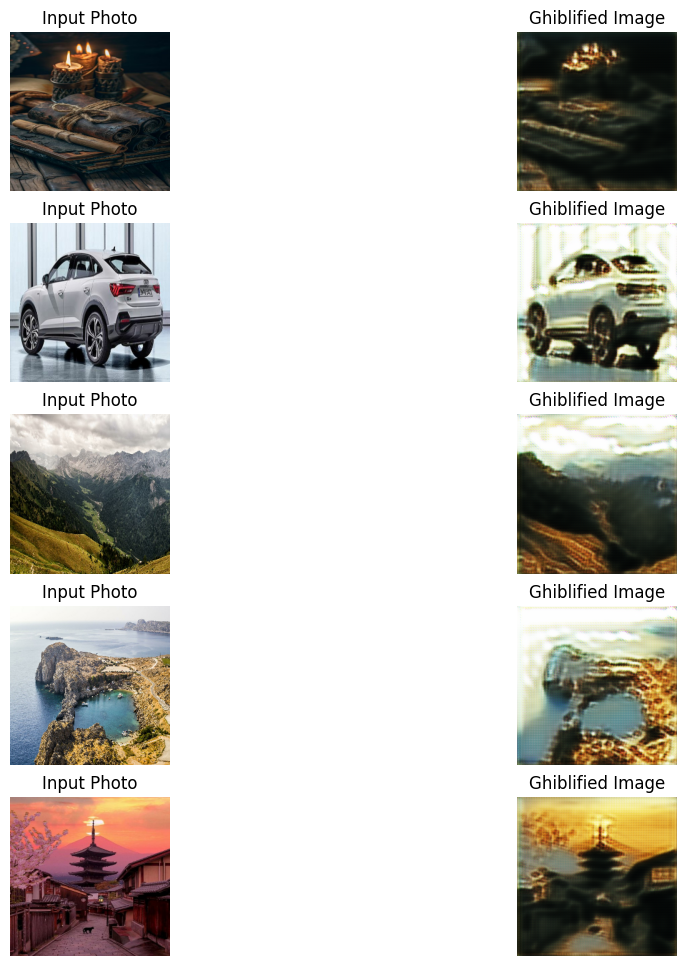

In [31]:
import matplotlib.pyplot as plt

_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(real_ds.take(5)):
    prediction = ghibli_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Ghiblified Image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()